# Sensitivity Analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import datetime

import os
import math
import scipy.stats
import sklearn
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from OU import OU
import nbimporter
from Feature_Creation import sma,rpmi,rvi,obv,obv_ema,oscK,oscD,ewma,mfi,rsi,create_label_func
from Backtesting_backup_models import create_pl_df,param_format,sharpe,sortino,precision,maxdrawdown,fit,find_profit_loss

%load_ext autoreload
%autoreload 2

In [2]:
def data_preprocessing(feature_window=5):
    
    df_ua = pd.read_csv('./data/df_ua.csv')
    df_uaa = pd.read_csv('./data/df_uaa.csv')

    df_ua['sma'] = sma(df_ua['close'], feature_window).pct_change()
    df_uaa['sma'] = sma(df_uaa['close'], feature_window).pct_change()

    df_ua['rpmi'] = rpmi(df_ua['close'], feature_window).pct_change().fillna(0)
    df_uaa['rpmi'] = rpmi(df_uaa['close'], feature_window).pct_change().fillna(0)

    df_ua['rvi'] = rvi(df_ua, feature_window).pct_change().fillna(0)
    df_uaa['rvi'] = rvi(df_uaa, feature_window).pct_change().fillna(0)

    df_ua['obv'] = obv(df_ua, feature_window).pct_change()
    df_uaa['obv'] = obv(df_uaa, feature_window).pct_change()

    df_ua['obv_ema'] = obv_ema(df_ua, feature_window).pct_change()
    df_uaa['obv_ema'] = obv_ema(df_uaa, feature_window).pct_change()

    #df_ua['oscK'] = oscK(df_ua, feature_window).pct_change()
    #df_uaa['oscK'] = oscK(df_uaa, feature_window).pct_change()

    df_ua['oscD'] = oscD(df_ua, feature_window).pct_change().fillna(0)
    df_uaa['oscD'] = oscD(df_uaa, feature_window).pct_change().fillna(0)

    df_ua['ewma'] = ewma(df_ua['close'], feature_window).pct_change()
    df_uaa['ewma'] = ewma(df_uaa['close'], feature_window).pct_change()

    df_ua['mfi'] = mfi(df_ua, feature_window).pct_change()
    df_uaa['mfi'] = mfi(df_uaa, feature_window).pct_change()

    df_ua['rsi'] = rsi(df_ua, feature_window).pct_change()
    df_uaa['rsi'] = rsi(df_uaa, feature_window).pct_change()

    df_ua['price'] = df_ua['close'].pct_change()
    df_uaa['price'] = df_uaa['close'].pct_change()

    # Remove NaNs from rolling features (sma, mfi, rsi...) from dataset. 
    df_ua_processed = df_ua[feature_window+1:].replace([np.inf, -np.inf], np.nan)
    df_uaa_processed = df_uaa[feature_window+1:].replace([np.inf, -np.inf], np.nan)
    df_ua_processed = df_ua_processed.fillna(0).reset_index(drop=True)
    df_uaa_processed = df_uaa_processed.fillna(0).reset_index(drop=True)
    
    df_ua_processed.to_csv('./data/df_ua_%d.csv'%feature_window)
    df_uaa_processed.to_csv('./data/df_uaa_%d.csv'%feature_window)

In [26]:
def whole_pipeline(feature_window=5,train_size=2000,test_size=100,threshold=0.0005,window=5,model='KNN',params=None,plot=False):
    """
    Performs the entire pipeline given some pre-decided inputs. 

    Returns a pandas.Series of back-testing results. 
    
    :feature_window: (Looking-back) Window for feature-generation. In unit of 5 minutes. 
    :train_size: Size of train sets. 
    :test_size: Size of test sets. 
    :window: Evaluation window for how long we want to hold on to our position. 
    :threshold: How much of a residual shift determines a trade being offloaded. 
    :model: Type of model used.
    :params: Hyper-parameters of models. (Defaultly use the best parameter sets found by grid search.)
    :plot: Flag for evaluation plots. 
    
    :pl_info: back-testing results. 
    """
    
    ## Step 1: Preprocess original data and create features (or load preprocessed data).
    
    df_ua_name = './data/df_ua_%d.csv'%feature_window
    df_uaa_name = './data/df_uaa_%d.csv'%feature_window
    if ~os.path.exists(df_ua_name) or ~os.path.exists(df_uaa_name):
        data_preprocessing(feature_window)
    df_ua_processed = pd.read_csv(df_ua_name)
    df_uaa_processed = pd.read_csv(df_uaa_name)    
    
    
    ## Step 2: Generate labels and split train-test datasets
    
    # Calculates parameters according to mean-reverting OU model. 
    OU_transform = OU(df_ua_processed, df_uaa_processed)
    # Perform labelling and spliting
    OU_transform.split_slide(m_size=train_size, e_size=test_size)
    label_func = create_label_func(threshold=threshold, window=window)
    cols = ['price', 'sma', 'rpmi', 'rvi', 'obv', 'obv_ema', 'oscD', 'ewma', 'mfi', 'rsi']
    info = OU_transform.get_splits(cols, label_func=label_func, scale=True)
    save_dir = "./data/info.npy"
    np.save(save_dir, info)
    df_pl = create_pl_df(df_ua_processed, df_uaa_processed, info)
    
    
    ## Step 3: Train models and backtest.
    
    if not params:
        # params is the particular set of parameters for models that we want to backtest 
        # (Use best set of parameters found through grid search if not specified)
        params = {'SVM': {'C': 100,
                          'cache_size': 2000,
                          'class_weight': {0: 0.6, 1: 0.4},
                          'gamma': 1,
                          'kernel': 'rbf'},
                  'RF':  {'max_depth': 30, 
                          'min_samples_leaf': 2, 
                          'min_samples_split': 5, 
                          'n_estimators': 20},
                  'XGB': {'gamma': 0.5, 
                          'learning_rate': 0.2, 
                          'max_depth': 7, 
                          'min_child_weight': 1, 
                          'n_estimators': 40, 
                          'subsample': 0.8},
                  'LR':  {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'},
                  'KNN': {'n_neighbors': 2},
                  'NB':  {'var_smoothing': 1.0},
                  'NN':  {'alpha': 0.31622776601683794, 
                          'hidden_layer_sizes': 4, 
                          'max_iter': 1000, 
                          'random_state': 1, 
                          'solver': 'lbfgs'}} 
    labels = fit(params[model], info, model)
    pl_info = find_profit_loss(df_pl, labels, params[model],window,threshold, plot=plot, save_dir=save_dir)
    pl_info = pd.Series(pl_info)
    
    
    return pl_info

## 1. Change models

In [8]:
res1 = pd.DataFrame()
for model in ['SVM','RF','XGB','LR','KNN','NB','NN']:
    info = whole_pipeline(model=model)
    info.name = model
    res1 = pd.concat([res1,info],axis=1)

Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: C-100_cache_size-2000_class_weight-006_104_gamma-1_kernel-rbf.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: max_depth-30_min_samples_leaf-2_min_samples_split-5_n_estimators-20.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:39:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:39:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: gamma-05_learning_rate-02_max_depth-7_min_child_weight-1_n_estimators-40_subsample-08.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Finding Profit/Loss for model with parameters: C-10000_penalty-l1_solver-liblinear.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: var_smoothing-10.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the

Finding Profit/Loss for model with parameters: alpha-031622776601683794_hidden_layer_sizes-4_max_iter-1000_random_state-1_solver-lbfgs.


In [11]:
res1.to_excel('./sensitivity/analysis1.xlsx')
res1.iloc[[0,4,6,7,8,9,10],:].T.sort_values('sharpe',ascending=False).T

,KNN,SVM,XGB,RF,NN,LR,NB
total_profit,26.70906,27.153042,26.098073,23.170375,23.828708,22.451203,16.725548
trades_executed,9659,13501,14116,14073,14861,15852,18098
precision,0.655945,0.659971,0.646954,0.644178,0.659406,0.654724,0.626444
mean_profit_per_trade,0.002765,0.002011,0.001849,0.001646,0.001603,0.001416,0.000924
sharpe,5.696146,5.27449,4.837797,4.428576,4.324226,3.938087,2.734854
sortino,10.350453,8.194018,7.319923,6.547131,6.672342,6.25382,4.002712
maxdd,-1.717432,-1.486943,-1.672383,-1.627968,-1.611992,-1.807917,-1.881346


## 2. Change hpyer-parameters for KNN(best model)

In [4]:
res2 = pd.DataFrame()
for num in [1,2,3,4,5]:
    info = whole_pipeline(model='KNN',params={'KNN': {'n_neighbors': num}})
    info.name = str(num)+'_neighbors'
    res2 = pd.concat([res2,info],axis=1)

Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-1.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-3.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-4.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-5.


In [6]:
res2.to_excel('./sensitivity/analysis2.xlsx')
res2.iloc[[0,4,6,7,8,9,10],:]

,1_neighbors,2_neighbors,3_neighbors,4_neighbors,5_neighbors
total_profit,28.009619,26.70906,24.340237,25.269675,24.129867
trades_executed,13403,9659,14585,12265,15559
precision,0.645872,0.655945,0.640439,0.646683,0.637548
mean_profit_per_trade,0.00209,0.002765,0.001669,0.00206,0.001551
sharpe,5.161286,5.696146,4.287081,5.126931,4.282925
sortino,8.10773,10.350453,7.007958,8.798807,7.306435
maxdd,-1.872809,-1.717432,-1.809804,-1.558861,-1.731144


## 3. Change feature-generating (looking-back) window

In [4]:
res3 = pd.DataFrame()
for num in [3,5,6,9,12]:
    info = whole_pipeline(feature_window=num)
    info.name = str(num*5)+'_mins'
    res3 = pd.concat([res3,info],axis=1)

Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.


In [5]:
res3.to_excel('./sensitivity/analysis3.xlsx')
res3.iloc[[0,4,6,7,8,9,10],:]

,15_mins,25_mins,30_mins,45_mins,60_mins
total_profit,19.49925,26.70906,26.552636,25.421385,22.53345
trades_executed,9886,9659,9971,9912,9822
precision,0.657882,0.655945,0.651371,0.654325,0.648073
mean_profit_per_trade,0.001972,0.002765,0.002663,0.002565,0.002294
sharpe,4.354563,5.696146,5.504502,5.049031,4.647615
sortino,6.269385,10.350453,9.061617,8.291052,8.327797
maxdd,-1.368585,-1.717432,-1.51709,-1.829678,-1.465946


## 4. Change holding window

In [18]:
res4 = pd.DataFrame()
for num in [2,4,5,6,8,12]:
    info = whole_pipeline(window=num)
    info.name = str(num*5)+'_mins'
    res4 = pd.concat([res4,info],axis=1)

Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.


In [19]:
res4.to_excel('./sensitivity/analysis4.xlsx')
res4.iloc[[0,4,6,7,8,9,10],:]

,10_mins,20_mins,25_mins,30_mins,40_mins,60_mins
total_profit,22.099291,27.608214,26.70906,26.010223,24.508808,19.022219
trades_executed,3355,8612,9659,10614,11952,13476
precision,0.42066,0.614992,0.655945,0.683958,0.711173,0.728974
mean_profit_per_trade,0.006587,0.003206,0.002765,0.002451,0.002051,0.001412
sharpe,6.178152,6.311555,5.696146,5.300715,4.599154,3.214705
sortino,15.010726,11.755964,10.350453,9.055297,7.897186,4.897113
maxdd,-1.454931,-1.601422,-1.717432,-1.932351,-2.109919,-1.983316


## 5. Change threshold for trading

In [16]:
res5 = pd.DataFrame()
for num in [3,4,5,6,8,10]:
    print(num)
    info = whole_pipeline(threshold=num*0.0001)
    info.name = 'thre_'+str(num)
    res5 = pd.concat([res5,info],axis=1)

3
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
4
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
5
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
6
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
8
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
10
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.


In [17]:
res5.to_excel('./sensitivity/analysis5.xlsx')
res5.iloc[[0,4,6,7,8,9,10],:]

,thre_3,thre_4,thre_5,thre_6,thre_8,thre_10
total_profit,30.754287,28.256498,26.70906,25.835641,22.489629,20.588874
trades_executed,10715,10191,9659,8974,7670,6681
precision,0.708568,0.681784,0.655945,0.629518,0.573252,0.514729
mean_profit_per_trade,0.00287,0.002773,0.002765,0.002879,0.002932,0.003082
sharpe,6.496497,6.071171,5.696146,5.614227,4.64648,4.259594
sortino,12.108154,10.975071,10.350453,9.789951,7.401965,7.120458
maxdd,-1.706963,-1.679075,-1.717432,-1.709278,-1.947573,-1.769883


## 6. Change size of train-sets

In [18]:
res6 = pd.DataFrame()
for num in [1500,2000,2500,3000,4000,5000]:
    print(num)
    info = whole_pipeline(train_size=num)
    info.name = 'train_'+str(num)
    res6 = pd.concat([res6,info],axis=1)

1500
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
2000
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
2500
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
3000
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
4000
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
5000
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.


In [20]:
res6.to_excel('./sensitivity/analysis6.xlsx')
res6.iloc[[0,4,6,7,8,9,10],:]

,train_1500,train_2000,train_2500,train_3000,train_4000,train_5000
total_profit,20.773176,26.70906,21.761937,25.16764,23.446882,22.03542
trades_executed,9668,9659,9792,9542,9033,8883
precision,0.648453,0.655945,0.655822,0.660376,0.657214,0.660195
mean_profit_per_trade,0.002149,0.002765,0.002222,0.002638,0.002596,0.002481
sharpe,4.177655,5.696146,4.531391,5.229432,4.862082,4.405276
sortino,5.728066,10.350453,6.927574,9.058735,8.520251,7.37141
maxdd,-1.573746,-1.717432,-1.363781,-1.907192,-1.843989,-2.525954


## 7. Change size of test-sets

In [23]:
res7 = pd.DataFrame()
for num in [50,80,100,150,200]:
    print(num)
    info = whole_pipeline(test_size=num)
    info.name = 'test_'+str(num)
    res7 = pd.concat([res7,info],axis=1)

150
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.
200
Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.


In [24]:
res7.to_excel('./sensitivity/analysis7.xlsx')
res7.iloc[[0,4,6,7,8,9,10],:]

,test_50,test_80,test_100,test_150,test_200
total_profit,25.255757,22.428921,26.70906,19.838021,23.750751
trades_executed,9572,9973,9659,10194,10048
precision,0.625756,0.640184,0.655945,0.661027,0.665517
mean_profit_per_trade,0.002639,0.002249,0.002765,0.001946,0.002364
sharpe,5.17767,4.72907,5.696146,4.106727,4.535364
sortino,7.357179,7.214433,10.350453,5.347348,7.54315
maxdd,-1.602049,-1.57703,-1.717432,-1.671451,-2.25446


## 8. Compare best results so far with simple mean-reversion strategy

Sliding Window Split Successful.
P/L Dataframe saved as "df_residual" parameter.


Backtesting_backup_models.ipynb:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "    \n",


Finding Profit/Loss for model with parameters: n_neighbors-2.


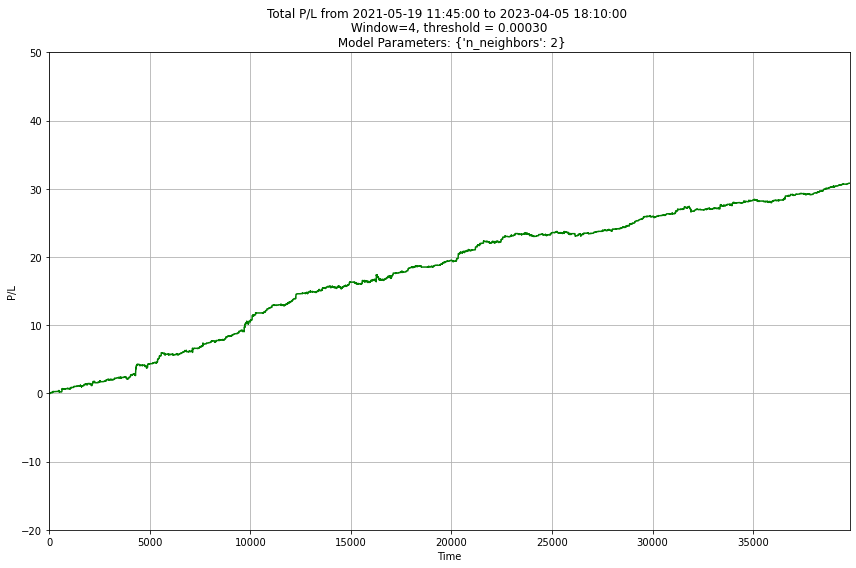

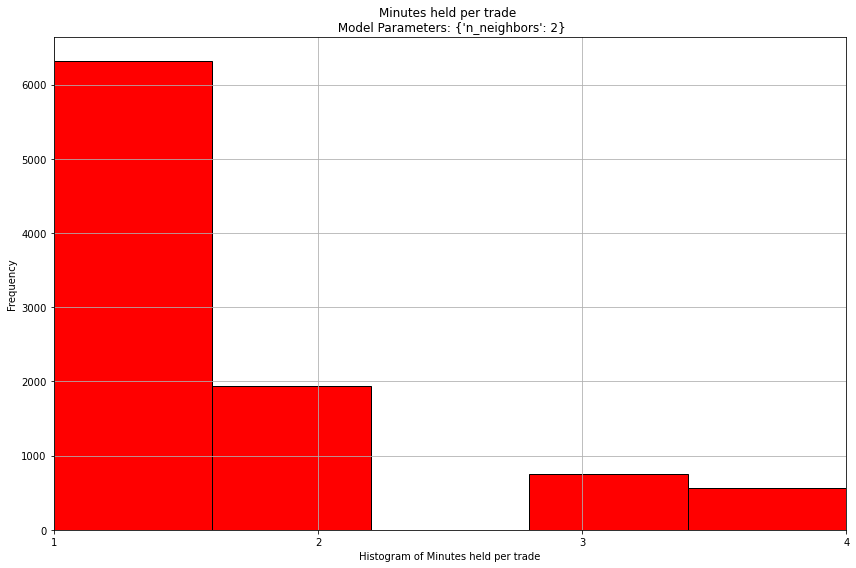

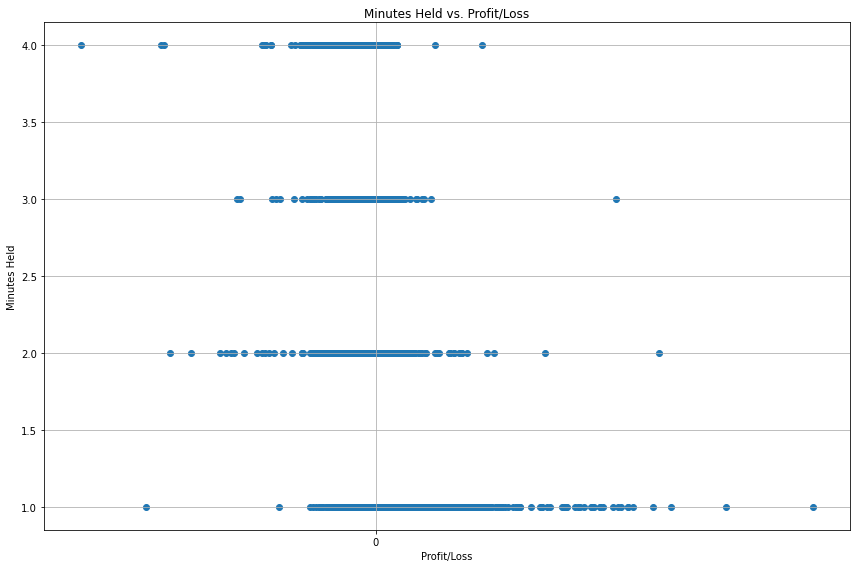

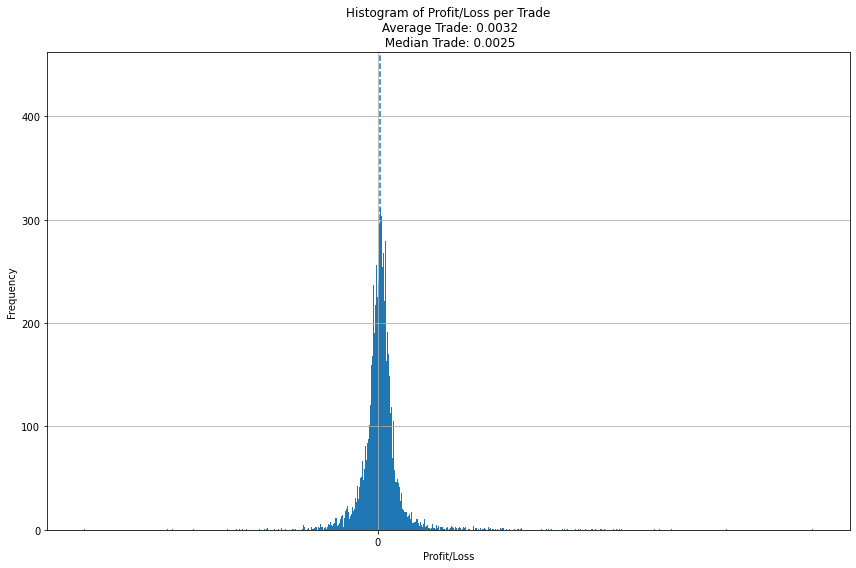

In [27]:
# results of our model under best settings
best_info = whole_pipeline(feature_window=5,train_size=2000,test_size=100,threshold=0.0003,window=4,model='KNN',params=None,plot=True)
best_info.name = 'best'

P/L Dataframe saved as "df_residual" parameter.
[array([-1.32679572, -5.21367962]), array([1.29905097, 5.12361214])]
Finding Profit/Loss for model with parameters: KNN-n_neighbors2.


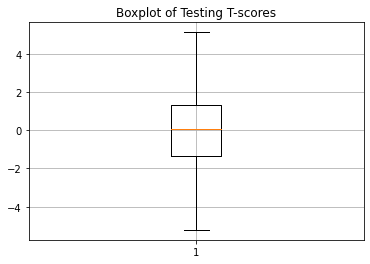

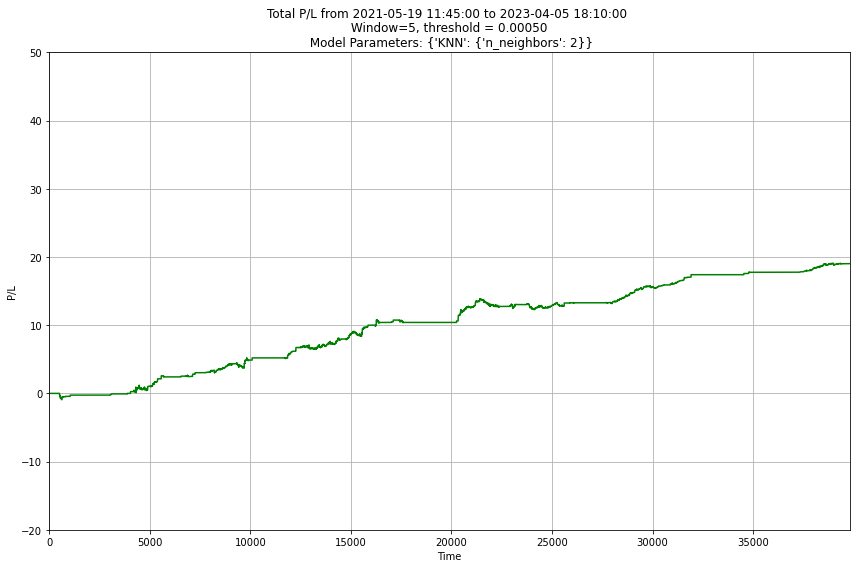

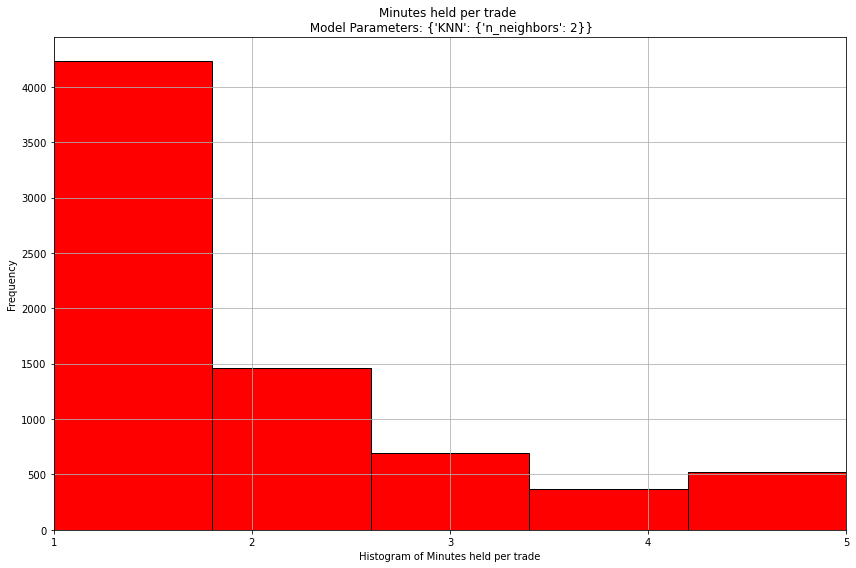

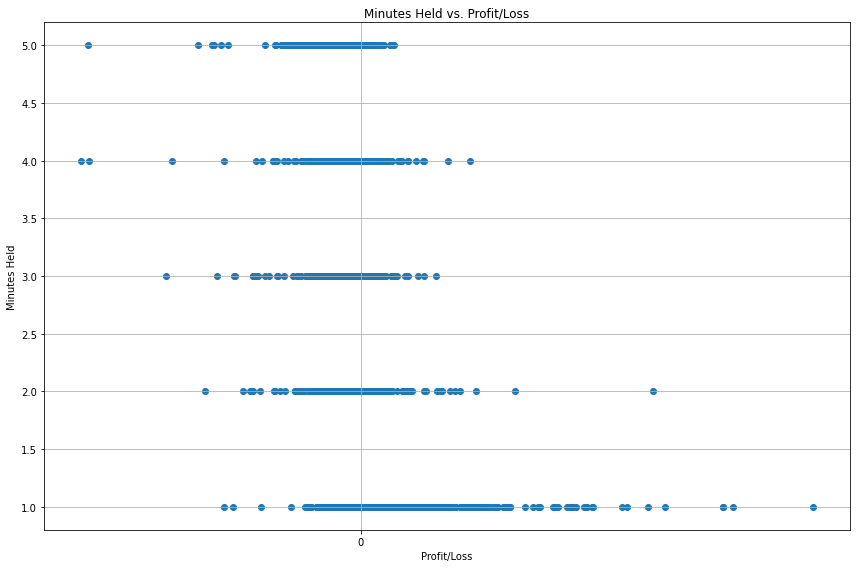

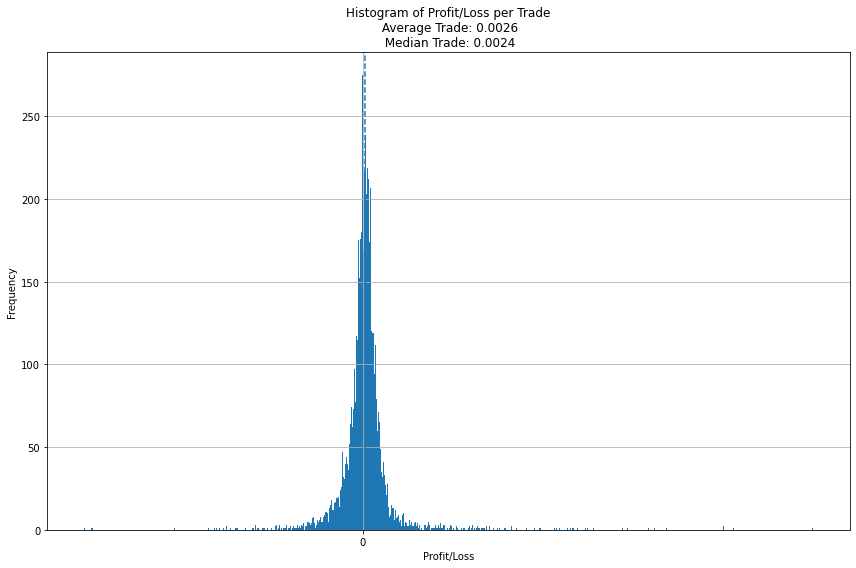

In [32]:
# results of simple mean-reversion strategy under the same settings
feature_window=5
df_ua_processed = pd.read_csv('./data/df_ua_%d.csv'%feature_window)
df_uaa_processed = pd.read_csv('./data/df_uaa_%d.csv'%feature_window)
info = np.load('./data/info.npy', allow_pickle=True)
df_pl = create_pl_df(df_ua_processed, df_uaa_processed, info)

df_tscore = pd.DataFrame()
for i in info:
    temp = i['test']['df']['price']
    df_tscore = pd.concat([df_tscore, temp], ignore_index=True)
    
plt.figure()
plt.title('Boxplot of Testing T-scores')
a = plt.boxplot(df_tscore[0], showfliers=False)
plt.grid()
print([item.get_ydata() for item in a['whiskers']])

tscore_label = [1 if x > 0.8 else 0 for x in list(df_tscore[0])]
tscore_info = find_profit_loss(df_pl, tscore_label, params={'KNN': {'n_neighbors':2}}, save_dir='./plots/backtesting/tscore')
tscore_info = pd.Series(tscore_info)
tscore_info.name = 'baseline'

In [33]:
# show and compare the results
res = pd.DataFrame()
res = pd.concat([res,best_info],axis=1)
res = pd.concat([res,tscore_info],axis=1)
res.iloc[[0,4,6,7,8,9,10],:]

,best,baseline
total_profit,30.819358,19.026356
trades_executed,9577,7273
precision,0.668879,0.656673
mean_profit_per_trade,0.003218,0.002616
sharpe,6.814232,4.135694
sortino,13.052556,5.153241
maxdd,-1.600944,-1.636946
